In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = '^GSPC'  # S&P 
START = '1965-01-01'
PARAM_PATH = '../data/inout_params.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed


Generating derived columns...
(15127, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1965-01-04 00:00:00+00:00,84.230003,84.230003,85.150002,83.769997,84.459999,4.433551,0.997277,1.004749,1.004749
1965-01-05 00:00:00+00:00,84.629997,84.629997,85.019997,84.019997,84.629997,4.438289,1.000000,1.003072,1.003072
1965-01-06 00:00:00+00:00,84.889999,84.889999,85.379997,84.449997,84.889999,4.441356,1.000000,1.004359,1.004359
1965-01-07 00:00:00+00:00,85.260002,85.260002,85.620003,84.660004,85.260002,4.445705,1.000000,1.001290,1.001290
1965-01-08 00:00:00+00:00,85.370003,85.370003,85.839996,84.910004,85.370003,4.446995,1.000000,1.000351,1.000351
1965-01-11 00:00:00+00:00,85.400002,85.400002,85.809998,84.900002,85.400002,4.447346,1.000000,1.002459,1.002459
1965-01-12 00:00:00+00:00,85.610001,85.610001,85.980003,85.129997,85.610001,4.449802,1.000000,1.002687,1.002687
1965-01-13 00:00:00+00:00,85.839996,85.839996,86.269997,85.349998,85.839996,4.452485,1.000000,1.000000,1.000000
1965-01-14 00:00:00+00:00,85.839996,85.839996,86.379997,85.410004,85.839996,4.452485,1.000000,1.004310,1.004310


In [3]:
SIM_START = pd.to_datetime('1983-01-04', utc=True)  # first day of legit open/close values
SIM_START

Timestamp('1983-01-04 00:00:00+0000', tz='UTC')

In [4]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [5]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [6]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

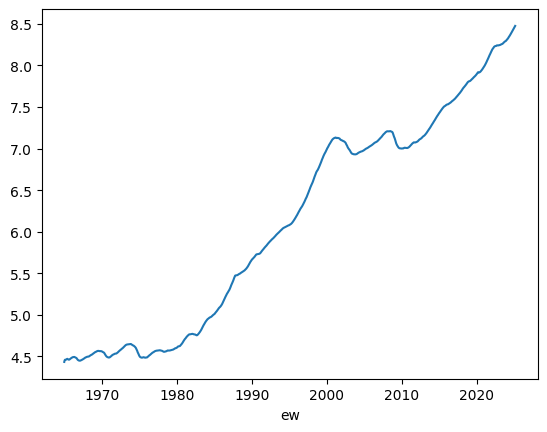

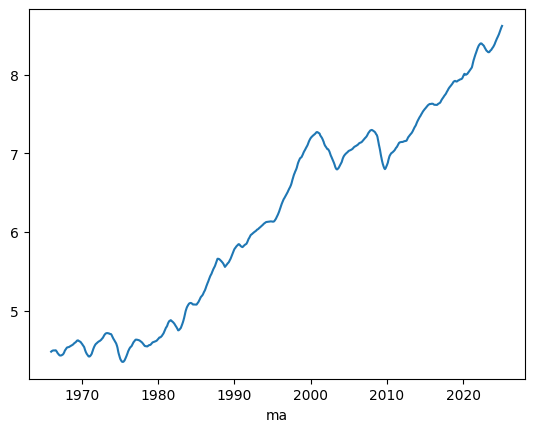

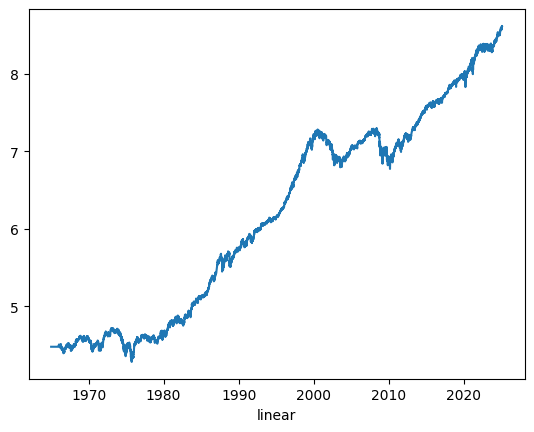

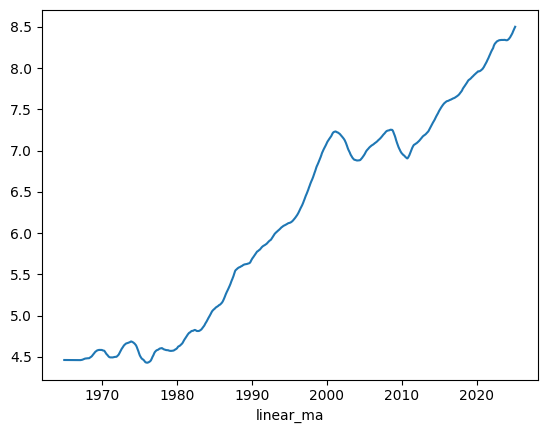

In [7]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [8]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [9]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [10]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [11]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [12]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [13]:
with open(PARAM_PATH, 'rb') as f:
    current_best, best_params = pickle.load(f)
#if 'transform_f' not in best_params:
#    best_params['transform_f'] = 'bounded_curve'
    
current_best, best_params

(133.69693772488716,
 {'time_param': 8,
  'method': 'linear',
  't': 0.899232316288312,
  'k': 6.131663754172292,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 43.97549195612643
Round 1: 132.42623949229414
New best: 132.42623949229414
{'time_param': 8, 'method': 'linear', 't': 0.899232316288312, 'k': 6.131663754172292, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


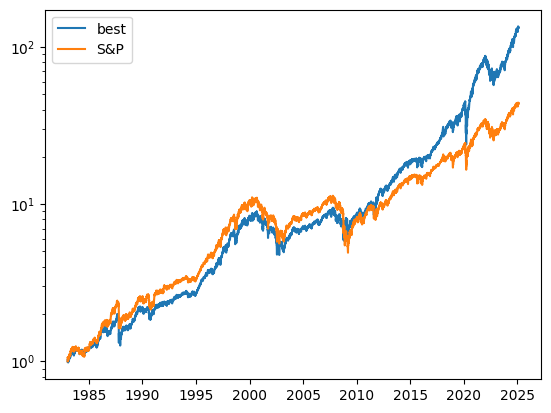

Round 2: 1.2898003814855679
Round 3: 9.34543244420614
Round 4: 16.090635974777904
Round 5: 29.818946629735294
Round 6: 3.0066207797630153
Round 7: 67.3122997928139
Round 8: 68.35667333564108
Round 9: 23.826918285007103
Round 10: 27.75410725122061
Round 11: 75.60917957626768
Round 12: 22.227048017631645
Round 13: 14.106788595336637
Round 14: 10.282517175085992
Round 15: 3.0921268066457785
Round 16: 13.60221288214666
Round 17: 4.62406377577622
Round 18: 18.0755451917857
Round 19: 24.593729229938237
Round 20: 60.73214505532195
Round 21: 69.61509135580638
Round 22: 10.183607350026612
Round 23: 9.526981988840555
Round 24: 7.52798961618424
Round 25: 6.5625847066286775
Round 26: 3.1803598422929173
Round 27: 1.5187785198324233
Round 28: 1.5874968762828656
Round 29: 6.668793869329562
Round 30: 10.152317263869602
Round 31: 4.614405545688077
Round 32: 3.0997609869828233
Round 33: 63.930436089550184
Round 34: 2.0396916728859704
Round 35: 2.040803896134506
Round 36: 10.110289493262586
Round 37: 20.

In [14]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [15]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 43.97549195612643
Round 1: 107.66224053087939
Round 2: 85.96184031728484
Round 3: 85.88744897525689
Round 4: 82.45525735698662
Round 5: 25.23489469120082
Round 6: 85.88290007655694
Round 7: 32.641711952456404
Round 8: 1.3036081516357438
Round 9: 33.8291858357845
Round 10: 91.68693990015865

Factor: 1.03125
Do nothing res: 43.97549195612643
Round 1: 43.34295321884146
Round 2: 107.25933744967345
Round 3: 25.108065216608246
Round 4: 86.37185453023338
Round 5: 52.82611137932399
Round 6: 85.93311350309207
Round 7: 85.94735514761682
Round 8: 45.3948956933196
Round 9: 26.32873517284176
Round 10: 92.59412232890892

Factor: 1.015625
Do nothing res: 43.97549195612643
Round 1: 85.95814172355115
Round 2: 85.9659982630138
Round 3: 92.88411310383957
Round 4: 3.4615411056684056
Round 5: 85.9253270493103
Round 6: 87.23270432537083
Round 7: 102.9556033341925
Round 8: 93.89638412630906
Round 9: 85.93618750932299
Round 10: 102.43669835899117

Factor: 1.0078125
Do nothing re

In [16]:
final_out = simulate(df, params_out)

In [17]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999999999999999

In [18]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.401163559434087

In [19]:
params_out

{'time_param': 8,
 'method': 'linear',
 't': 0.899232316288312,
 'k': 6.131663754172292,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


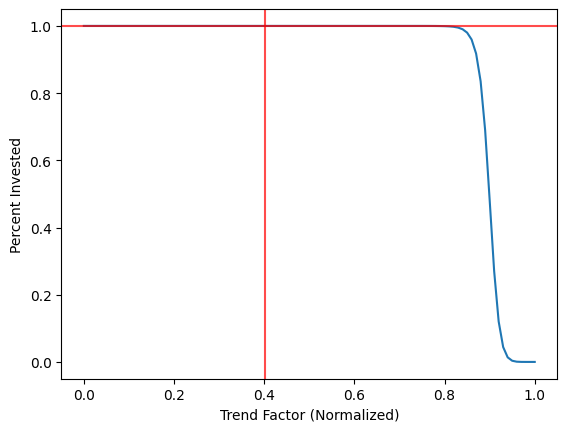

In [20]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

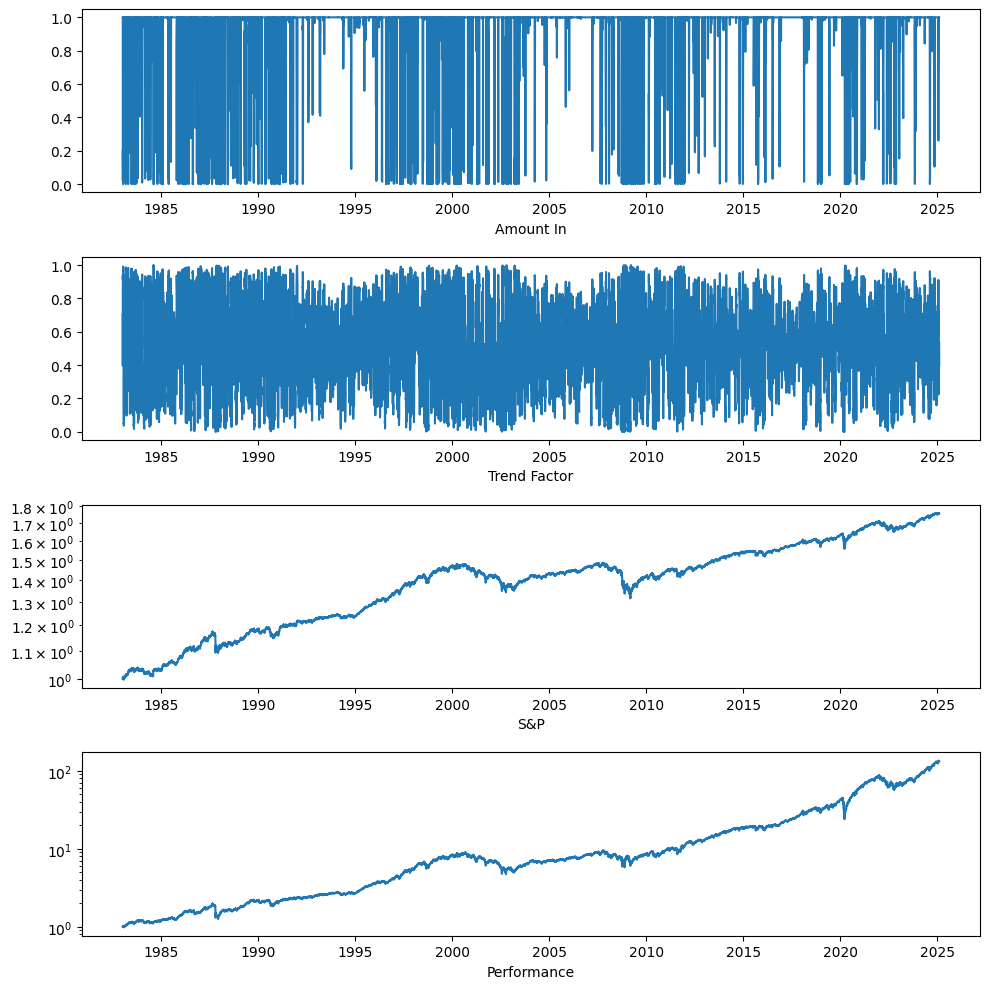

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('S&P')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [22]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('S&P')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

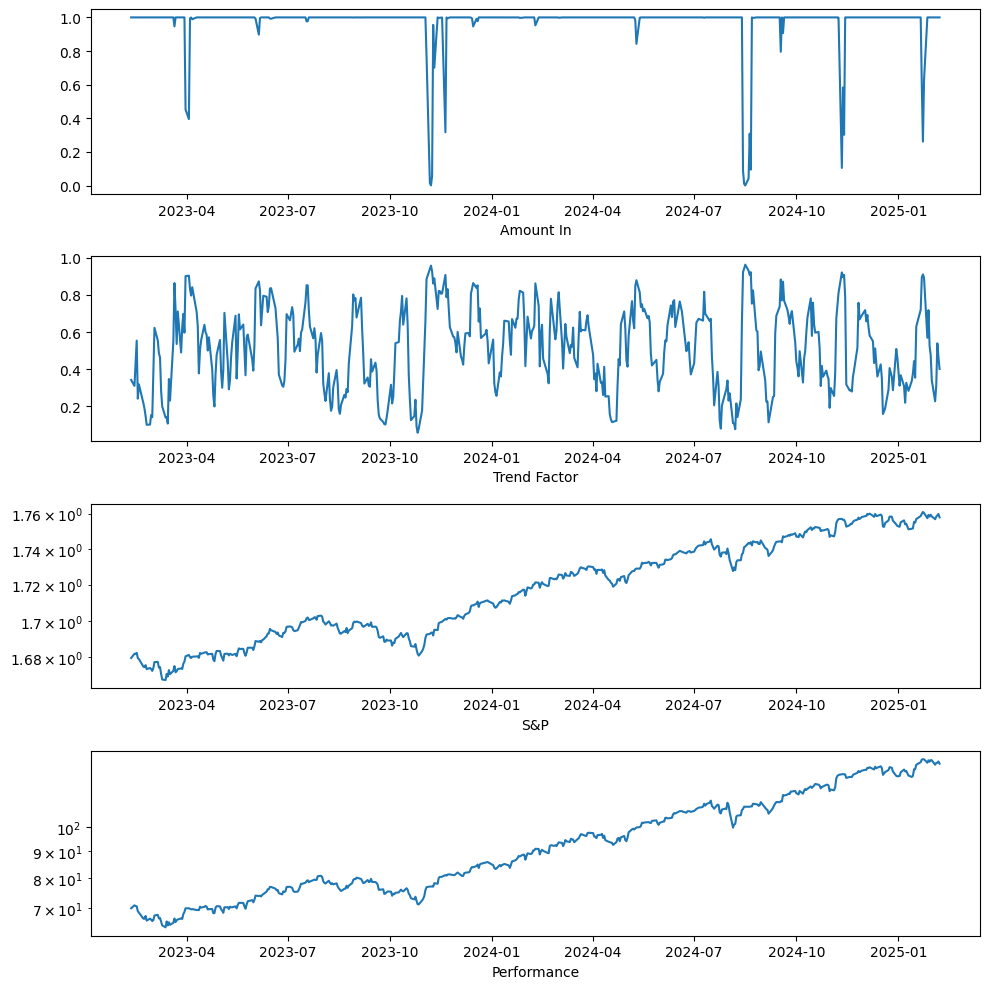

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('S&P')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [24]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [25]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(138.3300018310547, 42.44, 6083.1298828125)

In [26]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.12201687438292419

In [27]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['sp'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1220168743829242, 1.0], 'dia': [1.2207776459191888, 1.0], 'nas': [1.2421183774954494, 1.0], 'rus': [1.2956954303662476, 1.0], 'jpxn': [1.067609313829114, 1.0], 'ktec': [1.6317632641049638, 0.0], 'eem': [1.210138091847281, 1.0], 'nfty': [1.262556097182899, 1.0], 'gdx': [1.36786878147231, 0.0606]}


In [28]:
stop

NameError: name 'stop' is not defined

In [29]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(132.42623949229414,
 {'time_param': 8,
  'method': 'linear',
  't': 0.899232316288312,
  'k': 6.131663754172292,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})